<table style="border: none" align="left">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="5" color="black"><b>Use scikit-learn to predict the price of a Car - Batch deployment</b></th>
      <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="40" width="40"></th>
   </tr>
   <tr style="border: none">
      <th style="border: none"><img src="https://github.com/pmservice/wml-sample-notebooks/blob/master/images/PredictingCarPrice.png?raw=true" width="600" alt="Icon"> </th>
   </tr>
</table>

This notebook gives an insight on how to handle regression problems in data science. In machine learning, regression is used when the target (the variable that will be predicted) is numerical. There are various regression algorithms that can be used to predict numerical data and you will compare the results of three of them below.

In this notebook, you will use a data set of auto imports to predict the price of a car. This data set has 205 records, and you will split them into the training and testing sets after the data is loaded and cleaned. You will learn what steps to take to explore and prepare the data, create a model, and use Watson Machine Learning Client to save and deploy the model. 

The notebook uses `scikit-learn 0.20` and `watson-machine-learning-client-V4`.

Some familiarity with Python is helpful. This notebook is compatible Watson Studio Desktop and Python 3.6.

## Learning goals
- Load csv data.
- Display data using PixieDust.
- Explore data.
    - Handle missing values.
    - Visualize data in order to find significant predictors.
- Prepare data for training.
    - Train-test split.
    - One-hot encoding.
    - Feature scaling.
- Create, compare, and evaluate models.
- Use grid search to tune the model hyperparameters.
- Use Watson Machine Learning Client package.
    - Save, deploy, and score the selected model.

## Table of Contents
1. [Set up your environment](#setup)
2. [Load and explore data](#loaddata) <br>
    2.1 [Explore data](#explore)<br>
    2.2 [EDA and Feature selection](#featuresel)
3. [Data preparation](#dataprep)<br>
    3.1 [One-hot encoding](#encoding)<br>
    3.2 [Feature scaling](#scaling)
4. [Model selection](#model)<br>
    4.1 [Compare and evaluate models](#compare)<br>
    4.2 [Grid search](#gridsearch)<br>
    4.3 [Evaluate final model](#evaluate)
5. [Manage models in the WML Repository](#wml)<br>
    5.1 [Authenticate](#server)<br>
    5.2 [Save the model in the WML repository](#save)<br>
    5.3 [Load the model from the WML repository](#loadmodel)
6. [Deploy the selected model and score data](#deploy)<br>
    6.1 [Create a batch deployment for the published model](#create)<br>
    6.2 [Score data](#score)<br>
    6.3 [Delete the deployment and model](#delete)
7. [Summary and next steps](#summary)

<a id='setup'></a>
## 1. Set up your environment

Before you use the sample code in this notebook, you have to perform the following setup task:

- Install <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-install-over.html" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Server</a>.

<a id='loaddata'></a>
## 2. Load and explore data

In this section, the following topics will be covered:
- 2.1 [Explore data](#explore)
- 2.2 [EDA and Feature selection](#featuresel)

<a id='explore'></a>
### 2.1 Explore data

Load the data from the <a href="https://archive.ics.uci.edu/ml/datasets/automobile" target="_blank" rel="noopener no referrer">Auto Imports Database</a> available on UCI Machine Learning. 

You can use PixieDust to display items such as tables. PixieDust is an IBM open source add-on tool for Jupyter Notebooks used to explore and visualize data in such a way that it's easy to share and gather information from.

<div class="alert alert-block alert-warning">
To simply hide the output of pip install instead, use <tt>-q</tt> after <tt>!pip install</tt>.
</div>

In [ ]:
# Install pixiedust.
!pip install --upgrade pixiedust

In [2]:
# Import modules.
import numpy as np
import pandas as pd
import pixiedust

# Load data and set column names.
cars_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data', 
                        names = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 
                                 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 
                                 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 
                                 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'])
display(cars_data.head(10))

symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,nan,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
3,nan,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
1,nan,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
2,nan,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,15250.0
1,158.0,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,17710.0
1,nan,audi,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,18920.0
1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.4,8.3,140.0,5500.0,17,20,23875.0
2,192.0,bmw,gas,std,two,sedan,rwd,front,101.2,176.8,64.8,54.3,2395,ohc,four,108,mpfi,3.5,2.8,8.8,101.0,5800.0,23,29,16430.0


Here, you see a preview of the first 10 rows of the data. You can look at the values to get a sense of each column's data type. Also, taking note of the "?" values in some rows, you can infer that there are missing values in this data set. These will be handled later in this notebook. 

Run the cell below to get a list of the columns and their automatically assigned data types.

In [3]:
# Observe column data types.
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

In [4]:
# Display the number of records and features.
print('Number of rows: {}'.format(len(cars_data)))
print('Number of columns: {}'.format(len(cars_data.columns)))

Number of rows: 205
Number of columns: 26


The data set has 205 records and 26 features. As you can see, some of the data types are incorrectly marked as objects due to the missing values (represented by "?"). This can be fixed by running the following code, which converts the data type of the selected columns to numeric, replacing each missing value "?" with NaN. 

In [5]:
# Fix column data types.
cars_data[['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']] = cars_data[['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']].apply(pd.to_numeric, errors='coerce', axis=1)
display(cars_data.head())

symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,nan,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
3,nan,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
1,nan,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0


The missing values in each column can be counted using the following code.

In [6]:
# Check for missing values.
cars_data.isnull().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          0
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

The output shows us that the label, *price*,  is missing in 4 rows. Since you cannot make and evaluate predictions without the labels, those rows can be removed using the cell below. 

In [7]:
# Drop rows with missing target values.
cars_data.dropna(subset=['price'], inplace = True)
cars_data.isnull().sum()

symboling             0
normalized-losses    37
make                  0
fuel-type             0
aspiration            0
num-of-doors          0
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

Import the packages below to use for the exploratory data analysis.

In [8]:
# Import visualization packages.
import matplotlib.pyplot as plt
import seaborn as sns

You can visualize the price distribution of the cars by running the following cell.

Text(0, 0.5, 'count')

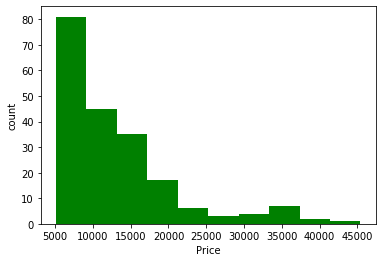

In [9]:
# Distribution of target value price.
plt.hist(x = cars_data['price'], bins = 10, color = 'green')
plt.xlabel('Price')
plt.ylabel('count')

Now, look at the distribution of the columns *with* their missing values and compare them to the column distributions once the missing values are replaced by the the column **mean**.

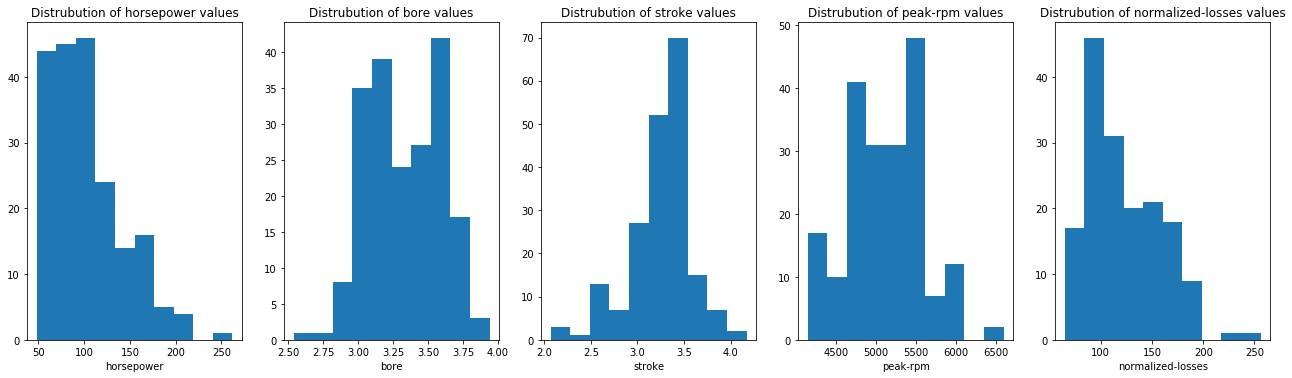

In [10]:
# Histograms of columns with missing values.
f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(18,5))
f.tight_layout()
ax = [ax1, ax2, ax3, ax4, ax5]
col = ['horsepower', 'bore', 'stroke', 'peak-rpm', 'normalized-losses']
for i in range (len(ax)):
    x_hist = cars_data[col[i]].dropna(inplace=False)

    ax[i].hist(x = x_hist, bins = 10)
    ax[i].set_xlabel(col[i])
    ax[i].set_title('Distrubution of ' + col[i] + ' values')

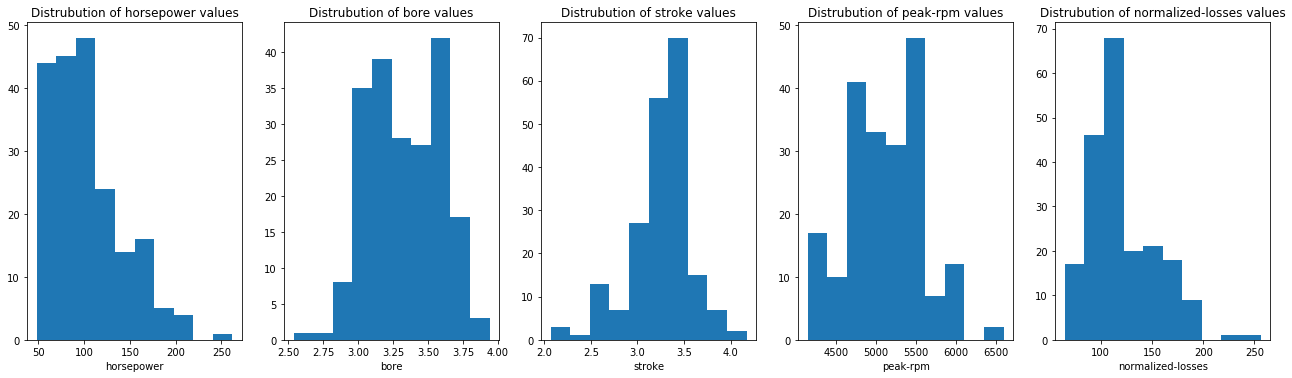

In [11]:
# Histograms of columns with adjusted missing values.
f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(18,5))
f.tight_layout()
ax = [ax1, ax2, ax3, ax4, ax5]
col = ['horsepower', 'bore', 'stroke', 'peak-rpm', 'normalized-losses']
for i in range (len(ax)):
    x_hist = cars_data[col[i]].fillna(value=cars_data[col[i]].mean(), inplace=False)
    
    ax[i].hist(x = x_hist, bins = 10)
    ax[i].set_xlabel(col[i])
    ax[i].set_title('Distrubution of ' + col[i] + ' values')

The distribution does not change significantly for *horsepower*, *bore*, *stroke*, and *peak-rpm*, so for these columns, this method can be used to replace the missing values  without significantly affecting the predictions.

In [12]:
for col in ['horsepower', 'bore', 'stroke', 'peak-rpm']:
    cars_data[col].fillna(cars_data[col].mean(), inplace=True)

### 2.2 EDA and Feature selection<a id='featuresel'></a>

In order to make accurate predictions, you need to select the significant numerical predictors by choosing the features most highly correlated to the label, *price*.

In [13]:
# Correlation of numerical values.
cars_data.corr()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
symboling,1.000000,0.528667,-0.535987,-0.365404,-0.242423,-0.550160,-0.233118,-0.110581,-0.139896,-0.007992,-0.182196,0.075790,0.279719,-0.035527,0.036233,-0.082391
normalized-losses,0.528667,1.000000,-0.074362,0.023220,0.105073,-0.432335,0.119893,0.167365,-0.033506,0.066413,-0.132654,0.295772,0.264597,-0.258502,-0.210768,0.203254
wheel-base,-0.535987,-0.074362,1.000000,0.876024,0.814507,0.590742,0.782097,0.572027,0.493203,0.157964,0.250313,0.371250,-0.360233,-0.470606,-0.543304,0.584642
length,-0.365404,0.023220,0.876024,1.000000,0.857170,0.492063,0.880665,0.685025,0.608941,0.123913,0.159733,0.579731,-0.286035,-0.665192,-0.698142,0.690628
width,-0.242423,0.105073,0.814507,0.857170,1.000000,0.306002,0.866201,0.729436,0.544879,0.188814,0.189867,0.615006,-0.245852,-0.633531,-0.680635,0.751265
height,-0.550160,-0.432335,0.590742,0.492063,0.306002,1.000000,0.307581,0.074694,0.180327,-0.060822,0.259737,-0.086941,-0.309913,-0.049800,-0.104812,0.135486
curb-weight,-0.233118,0.119893,0.782097,0.880665,0.866201,0.307581,1.000000,0.849072,0.644041,0.167412,0.156433,0.757994,-0.279350,-0.749543,-0.794889,0.834415
engine-size,-0.110581,0.167365,0.572027,0.685025,0.729436,0.074694,0.849072,1.000000,0.572516,0.205806,0.028889,0.822649,-0.256753,-0.650546,-0.679571,0.872335
bore,-0.139896,-0.033506,0.493203,0.608941,0.544879,0.180327,0.644041,0.572516,1.000000,-0.055390,0.001250,0.566838,-0.267338,-0.582121,-0.591390,0.543154
stroke,-0.007992,0.066413,0.157964,0.123913,0.188814,-0.060822,0.167412,0.205806,-0.055390,1.000000,0.187854,0.097815,-0.063720,-0.034079,-0.034741,0.082267


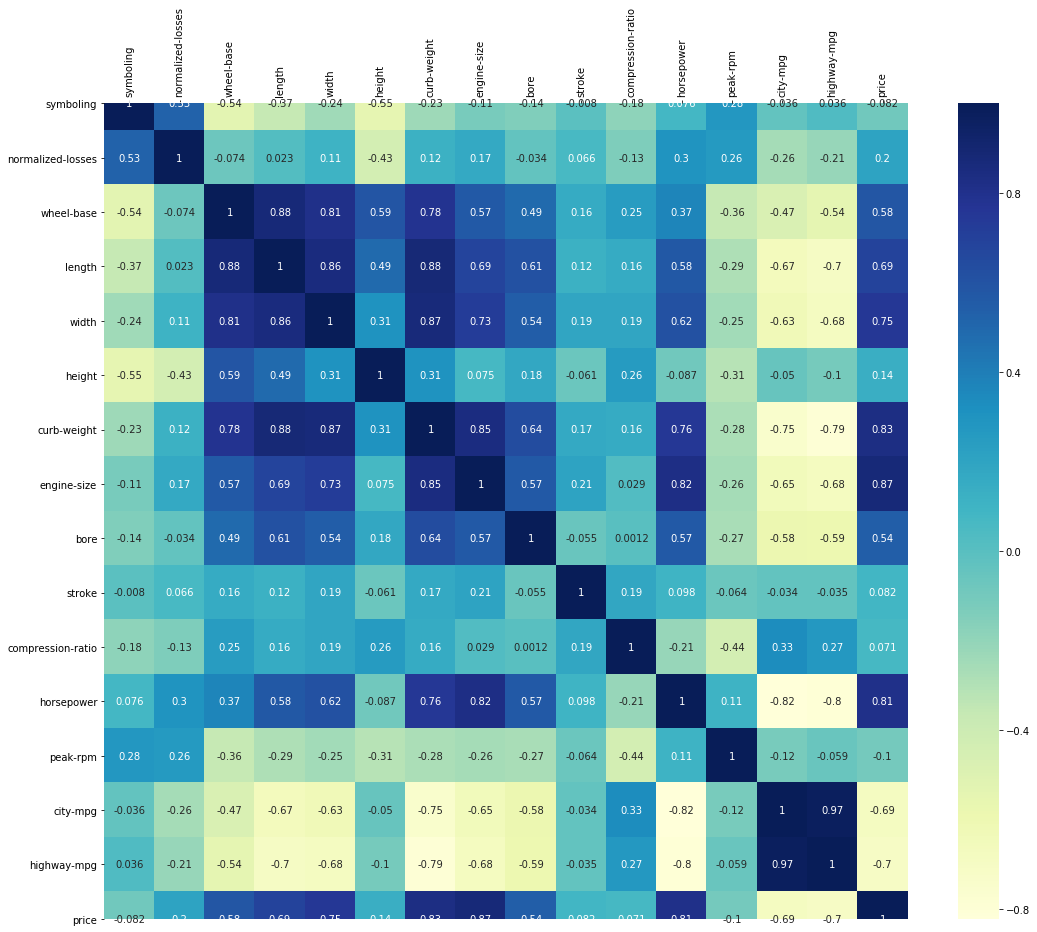

In [14]:
# Plot a correlation heatmap.
plt.subplots(figsize=(18,15))
hm1 = sns.heatmap(cars_data.corr(), annot=True, cmap='YlGnBu')
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90)
hm1.xaxis.set_ticks_position('top')

Although the *normalized-losses* column has many NaNs, it doesn't appear to be a significant predictor. So, the missing values do not need to be filled in this case. 

By plotting the correlation heatmap of the numerical columns with the target *price*, you can pick out the significant numerical features/predictors. The features that are highly correlated are also eliminated **(ex: > 0.95)**. Therefore, you can choose *width*, *engine-size*, and *highway-mpg* as the numerical predictors for the model.

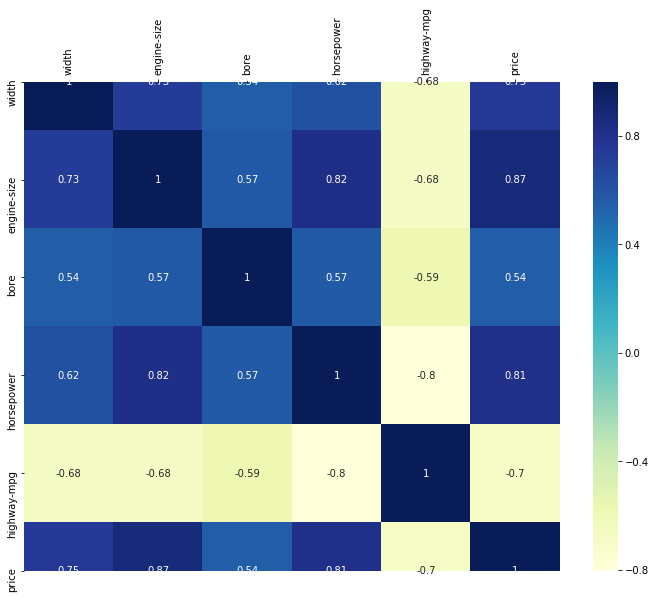

In [15]:
# Plot correlation heatmap of selected numerical features.
plt.subplots(figsize=(12, 9))
hm2 = sns.heatmap(cars_data[['width', 'engine-size', 'bore', 'horsepower', 'highway-mpg', 'price']].corr(), annot=True, cmap='YlGnBu')
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=90)
hm2.xaxis.set_ticks_position('top')

By plotting the boxplots of each categorical column against the price, you can pick out the significant features. More variation in the boxplot implies higher significance. Therefore you can choose *make*, *engine-location*, *num-of-cylinders*, and *fuel-system* as predictors for the model.

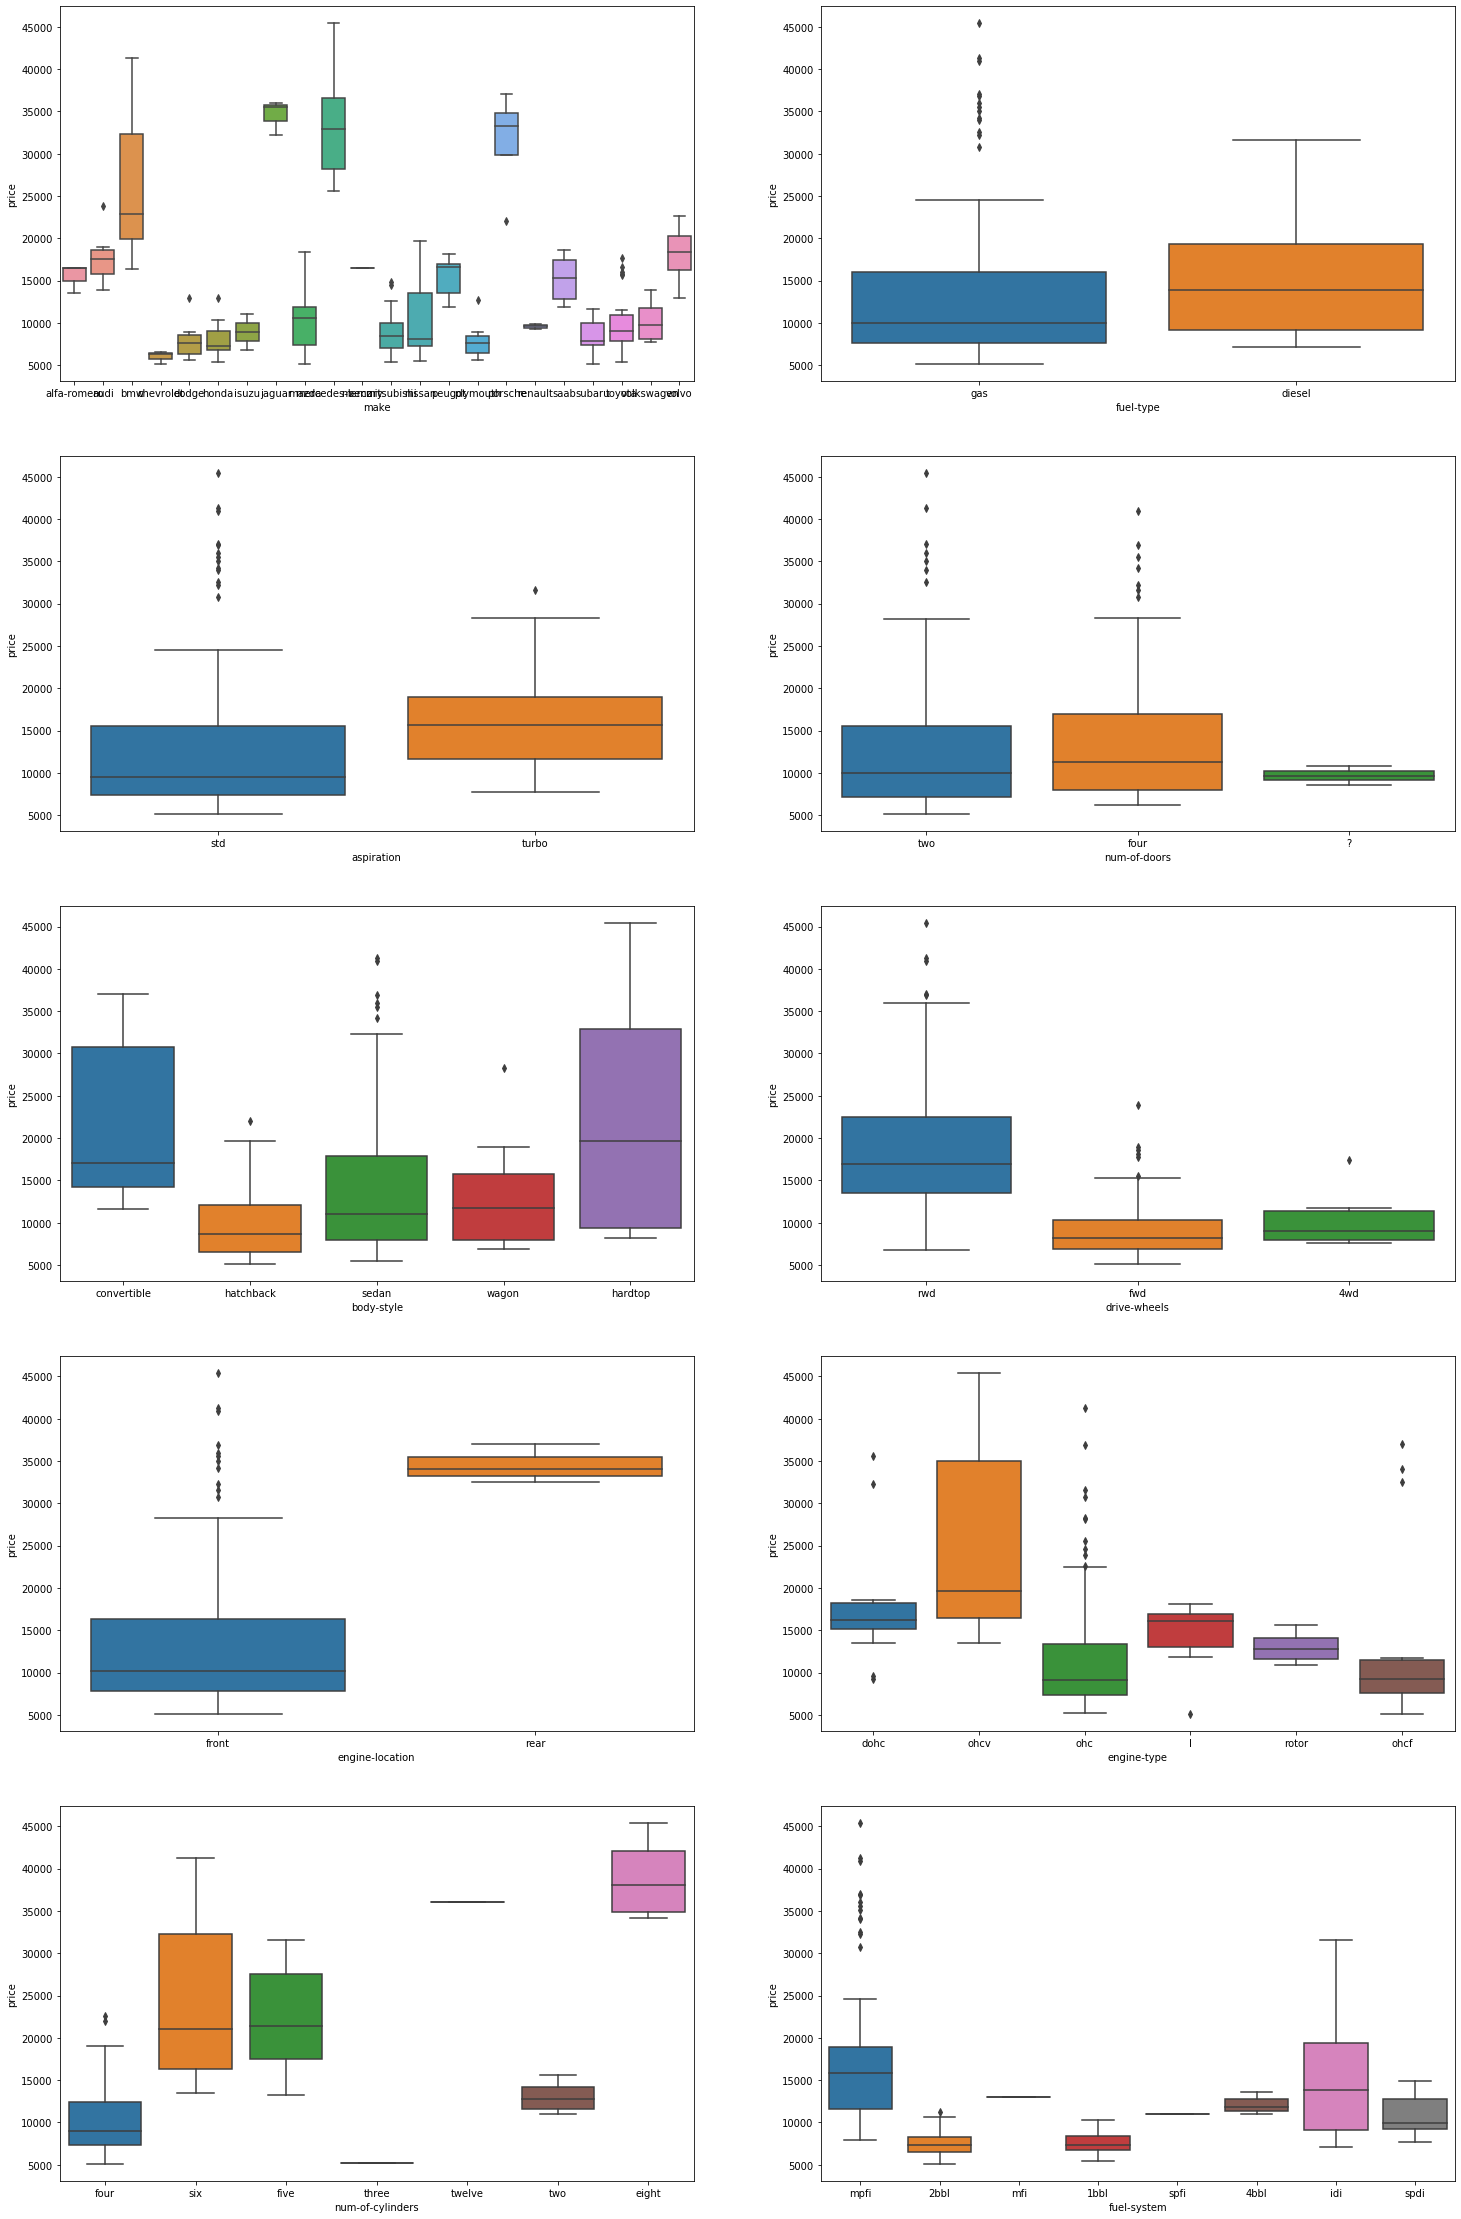

In [16]:
# Plot boxplots of categorical columns.
cat_list = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system']
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(25, 40))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

for i in range(len(cat_list)):
    sns.boxplot(x = cat_list[i], y = 'price', data=cars_data, ax=ax[i])

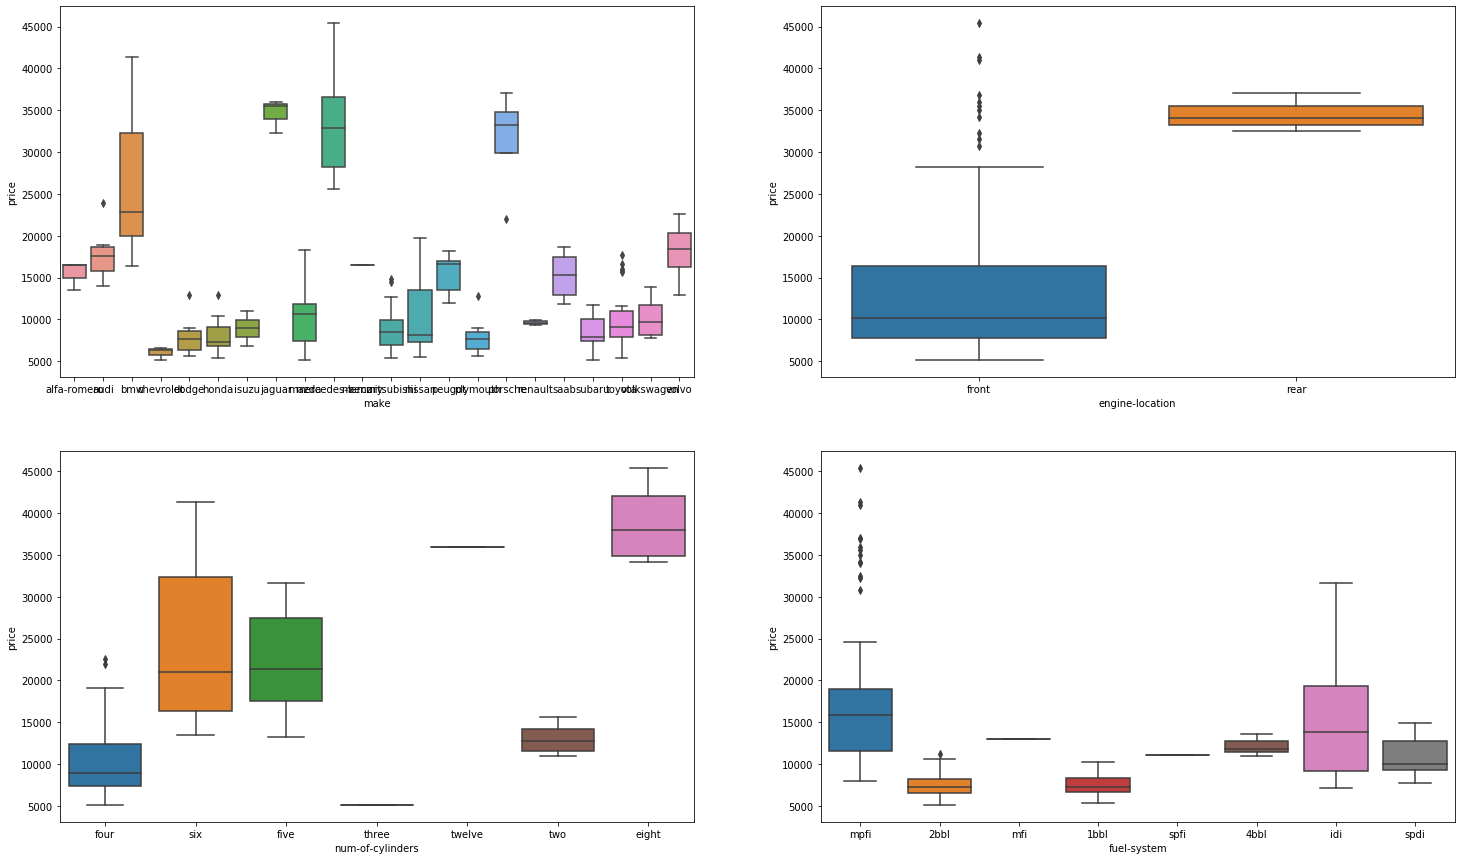

In [17]:
# Plot boxplots of selected categorical columns:
# drive-wheels, engine-type.
cat_list2 = ['make', 'engine-location', 'num-of-cylinders', 'fuel-system']
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15))
ax = [ax1, ax2, ax3, ax4]

for i in range(len(cat_list2)):
    sns.boxplot(x = cat_list2[i], y = 'price', data=cars_data, ax=ax[i])

Now, the significant features *(make*, *engine-location*, *width*, *num-of-cylinders*, *engine-size*, *fuel-system*, and *highway-mpg)* and label *(price)* can be used to make the predictions.

<a id = 'dataprep'></a>
## 3. Data Preparation

This section will cover:
- 3.1 [One-hot encoding](#encoding)
- 3.2 [Feature scaling](#scaling)

### 3.1 One-hot encoding<a id='encoding'></a>

Now, the predictors can be set to a variable X and the target/label to variable y.

In [18]:
# Feature selection.
X = cars_data[['make', 'engine-location', 'width', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'horsepower', 'highway-mpg']]
y = cars_data.iloc[:, 25]

Many models take only numerical values as input. So, using the following code, the categorical columns are converted to dummy variables, a process called **one-hot encoding**. This means that each column is split into it's various categories, with a column of binary values for each category. One category/column is always omitted from each set of categories to prevent multicollinearity. 

For example, *engine-location* as 2 categories: *front* and *rear*. This is converted into 2 colums - one for each category - but one is dropped, leaving only *engine-location_rear*. The model will infer from this that '1' represents the *rear* category and '0' represents the *front* category.

In [19]:
# One-hot encoding.
X = pd.get_dummies(X, columns=['make', 'engine-location', 'num-of-cylinders', 'fuel-system'], drop_first=True)
X_copy = X.copy()

In [20]:
X = X.values

You can check the one-hot encoded columns.

In [21]:
with pd.option_context('display.max_columns', None):
    display(X_copy.head())

width,engine-size,bore,horsepower,highway-mpg,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,make_mercury,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_porsche,make_renault,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,engine-location_rear,num-of-cylinders_five,num-of-cylinders_four,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,num-of-cylinders_two,fuel-system_2bbl,fuel-system_4bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
64.1,130.0,3.47,111.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
64.1,130.0,3.47,111.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65.5,152.0,2.68,154.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66.2,109.0,3.19,102.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66.4,136.0,3.19,115.0,22.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Split the data set into training and test data sets.
- The train data set, which is the largest group, will be used for training
- The test data set will be used for model evaluation and is used to test the assumptions of the model

In [ ]:
!pip install --upgrade scikit-learn==0.20.4

In [23]:
# Split the data set to create training and testing sets, and separate the labels
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

In [24]:
# List the number of records in each data set.
print('Number of training records: ' + str(X_train.shape[0]))
print('Number of testing records : ' + str(X_test.shape[0]))

Number of training records: 160
Number of testing records : 41


### 3.2 Feature scaling<a id='scaling'></a>

Scale the data to prevent the different ranges of numerical predictors from skewing the predictions.

In [25]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.values.reshape(-1, 1))

In [26]:
y_train.shape

(160, 1)

In [27]:
y_train = y_train.reshape(160,)

<a id='model'></a>
## 4. Model selection

Model selection involves choosing the algorithm that best predicts the target in the given data set. This involves the following topics
- 4.1 [Compare and evaluate models](#compare)
- 4.2 [Grid search](#gridsearch)
- 4.3 [Evaluate final model](#evaluate)

<a id='compare'></a>
### 4.1 Compare and evaluate models

Here, you import the packages required for each algorithm. The model evaluation metrics are also imported, which will be used to choose the best model for prediction. Then, you create an object for each model, fit the model on the training data using the default hyperparameters, and predict the test values using this fitted model. 

In [28]:
# Fitting several regression models to the training set & comparing them.

# Import modules to create models.
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,  mean_squared_log_error, explained_variance_score
from numpy import sqrt
from sklearn.model_selection import cross_val_score

# Create regression objects.
lr = LinearRegression()
svr = SVR(kernel = 'linear')
dt = DecisionTreeRegressor(random_state = 0)

y_df = pd.DataFrame({'y_test' : y_test.values})

# Create models and predictions using each method - compare them.
for reg in [lr, svr, dt]:
    
    # Train the model.
    reg.fit(X_train, y_train)
    print(reg)
    print('CV: ' + str(cross_val_score(reg, X, y, cv=10)))
    
    # Predict using test set.
    y_pred = reg.predict(X_test)
    y_pred = sc_y.inverse_transform(y_pred)
    print(y_pred)
    
    y_df[str(reg)[:3]] = pd.DataFrame(y_pred)
    
    # Evaluate variance and MSLE.
    print('Var: ' + str(explained_variance_score(y_test.values, y_pred)))
    print('MSLE: ' + str(mean_squared_log_error(y_test.values, y_pred)) + "\n\n")

print("Test labels:")
print(y_test.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
CV: [ 0.43846227  0.12679942  0.7065621   0.78964737  0.5277165   0.52984899
  0.5617717  -0.94635691  0.20613226  0.67179959]
[ 7108.2539399   5741.72049073  9598.01619923  6466.44400522
  6295.          6216.78408526 13287.78751264 13645.
 13287.78751264  6867.92821126  8964.19215491  9343.25003346
  8641.82540621  8365.9438635  13989.56494381  4657.21241702
 15775.48830757  9941.16153535 13287.78751264  5933.45900536
 11936.75115607  5741.72049073  9151.86360052 11936.75115607
 10362.92010497 19803.09681503  9941.16153535  8972.59481359
  9140.38242755 13645.         14872.88889601  5741.72049073
 16631.47574552 15982.29592434  9734.88666483  8910.63429491
 18032.12052196  9214.97810294  5741.72049073 20279.16276303
  6161.71686138]
Var: 0.5863835519329097
MSLE: 0.03325485081812845


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter

In [29]:
# Labels of test values.
print(y_test.values)

[ 6695.  7299.  9095.  7898.  6575.  7738.  9989. 11845.  8449.  8058.
  6989.  9980.  7898.  7957. 11900.  5399. 17450.  7975. 11199.  5572.
 11248.  6649.  9960.  9988. 11259. 16503.  8195.  8558.  9538. 10945.
 12629.  7499. 12940. 12764.  9279.  8013. 15998.  9233.  8249. 15040.
  6692.]


These are the predicted labels for the test set:

In [30]:
# Test labels vs predicted values.
display(y_df)

y_test,Lin,SVR,Dec
6695.0,7108.253939899679,6837.64993165195,6445.0
7299.0,5741.7204907289015,6351.341938561051,7098.999999999999
9095.0,9598.016199229296,9696.675112324312,8370.0
7898.0,6466.4440052212,7003.997046512454,8778.0
6575.0,6295.000000000038,7147.025169736167,6295.0
7738.0,6216.784085258606,6155.444016152305,7068.0
9989.0,13287.787512639046,12402.228853949171,12952.333333333334
11845.0,13644.999999999996,12791.160286903782,13645.0
8449.0,13287.787512639046,12402.228853949171,12952.333333333334
8058.0,6867.928211257764,7204.272104008742,8238.0


### 4.2 Grid search<a id='gridsearch'></a>

**Grid search** is used to choose the best hyperparameters for the model. The grid search package, **GridSearchCV**, uses cross validation to evaluate each model with different combinations of hyperparameters. This means that the data set is split into the number of folds specified (in this case, 10) and each unique model is tested with each fold of the data set and evaluated based on the specified metric (here, mean squared error).

In [31]:
# Use grid search to find the best parameters.
# Scoring methods - explained_variance, neg_mean_squared_error.
# Grid search parameters - 'max_features': [1, 2, 3, 4].
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [0.01, 0.1, 1, 10, 100], 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]}, {'min_samples_split' : range(10,100,10), 'max_depth': range(1,20,2)}]
models = [svr, dt]
for i in range(2):
    mod = GridSearchCV(estimator = models[i], param_grid = parameters[i], scoring='neg_mean_squared_error', cv=10, n_jobs=-1, return_train_score=True)
    print(mod.fit(X_train, y_train))
    print('Training MSE: ' + str(abs(mod.best_score_)))
    print('Test MSE: ' + str(abs(mod.score(X_test, sc_y.transform(y_test.values.reshape(-1, 1))))) + "\n\n")

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'epsilon': [0, 0.01, 0.1, 0.5, 1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)
Training MSE: 0.08918872292416183
Test MSE: 0.03327130800821584


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_g

These are the cross validation results that were evaluated by the grid search.

In [32]:
# Print model cross validation results.
for key in mod.cv_results_.keys():
    print(str(key) + ': \n' + str(mod.cv_results_[key]) + '\n\n')

mean_fit_time: 
[0.00028236 0.00022442 0.00019178 0.00019996 0.00019341 0.00018837
 0.00019662 0.00019958 0.00028951 0.00035567 0.00027399 0.00034266
 0.00033493 0.00035269 0.00039864 0.00027936 0.00029659 0.00024915
 0.00046656 0.00039859 0.00033321 0.00028954 0.00028217 0.00026314
 0.00026352 0.00026741 0.00023756 0.00042136 0.000366   0.00034928
 0.00029891 0.00027006 0.00026901 0.00026104 0.00025415 0.00024314
 0.00044012 0.00038977 0.00034227 0.00031891 0.00026467 0.00025816
 0.0002533  0.00025742 0.00022268 0.00047681 0.00039306 0.00034974
 0.00043495 0.00040653 0.0003444  0.00034659 0.00025887 0.00023682
 0.00047438 0.00039346 0.00038729 0.00032375 0.00043969 0.00045338
 0.00040801 0.00029693 0.00033669 0.00055621 0.00058584 0.00049109
 0.00033622 0.00028477 0.00037272 0.00042324 0.00035064 0.00026791
 0.00069778 0.00047114 0.00039296 0.00033641 0.00034218 0.00036232
 0.00046155 0.00040977 0.00026729 0.00052495 0.00050082 0.00035467
 0.00029964 0.00025826 0.00036011 0.00027249 0

### 4.3 Evaluate final model<a id='evaluate'></a>

The best estimator and the best MSE score can be found by running the following code.

In [33]:
# Find the best estimator.
print(mod.best_estimator_)
print('Training MSE: ' + str(abs(mod.best_score_)))

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')
Training MSE: 0.09208391363988426


The best estimator predicts the following prices when passed the test set:

In [34]:
# Predict on test set.
results = mod.predict(X_test)
sc_y.inverse_transform(results.reshape(1, -1))

array([[ 6809.60869565,  6809.60869565,  8398.5       ,  8778.        ,
         5705.66666667,  7963.        , 15035.85714286, 13865.76470588,
        15035.85714286,  7963.        ,  8398.5       ,  9239.42857143,
         7963.        ,  9239.42857143, 15355.        ,  5705.66666667,
        13865.76470588,  8398.5       , 15035.85714286,  5705.66666667,
         9984.22222222,  6809.60869565,  9853.85714286,  9984.22222222,
         9853.85714286, 18249.375     ,  8398.5       ,  9239.42857143,
         9239.42857143, 13865.76470588, 13865.76470588,  6809.60869565,
        15355.        , 13865.76470588,  9853.85714286,  7454.66666667,
        18249.375     , 13865.76470588,  6809.60869565, 13865.76470588,
         6809.60869565]])

In [35]:
# Mean squared error of test set.
print('Train MSE: ' + str(abs(mod.score(X_test, sc_y.transform(y_test.values.reshape(-1, 1))))))

Train MSE: 0.05852340939211963


## 5. Manage models in the WML Repository<a id='wml'></a>

In this section, you will learn how to use the common Python client to manage your model in the WML repository.
- 5.1 [Setting up](#server)
- 5.2 [Save the model in the WML repository](#save)
- 5.3 [Load the model from the WML repository](#loadmodel)

<div class="alert-block alert-info"><br> You can find more information about the watson-machine-learning-client <a href="https://wml-api-pyclient-dev-v4.mybluemix.net/">here</a>.<br><br></div>

### 5.1 Authenticate<a id='server'></a>

First, import the `WatsonMachineLearningAPIClient` module.

In [36]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

**Connect to the Watson Machine Learning Server using the Python client**<br><br>

<div class="alert-block alert-info"><br>
To install the Watson Machine Learning Server, follow <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-install-over.html" target="_blank" rel="noopener no referrer">these documentation steps</a>. To connect to the WML server and find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-connect.html" target="_blank" rel="noopener no referrer">Documentation</a>.<br><br>
</div>

**Action**: Enter your WML Server credentials in the following cell.

In [37]:
wml_credentials={
    'url': 'https://ibm-watson-ml.mybluemix.net',
    'username': '****',
    'password': '****',
    'instance_id': '****'
}

Instantiate the `WatsonMachineLearningAPIClient` object.

In [39]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 5.2 Save the model in the WML repository<a id='save'></a>

Create the model metadata to store in the repository. You can obtain the space UID (one of the MetaNames in the model metadata) by using the following cells.

<div class="alert-block alert-info"><br>
You can create your own deployment space by selecting <b>Deployment Spaces</b> from the Navigation Menu on the top left of this page.<br><br></div>

In [41]:
# Obtain the UId of your space
def guid_from_space_name(client, space_name):
    instance_details = client.service_instance.get_details()
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')`.

In [42]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')
print("Space UID = " + space_uid)

Space UID = 911ab599-de04-46a7-9cd9-ba3723cec125


In [43]:
# Model Metadata.
meta_props={
    client.repository.ModelMetaNames.NAME: "Car Price Regression model",
    client.repository.ModelMetaNames.RUNTIME_UID: "scikit-learn_0.20-py3.6",
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.20"
}

You need the model UID to create the deployment. You can extract the model UID from the saved model details and use it in the next section to create the deployment.

In [44]:
# Create the model artifact.
model_artifact = client.repository.store_model(mod,
                                                   meta_props=meta_props,
                                                   training_data=X_train,
                                                   training_target=y_train)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)

Model UID = 6bab0ed4-03e9-4af0-ab5a-249c9be58534


Get the saved model metadata from WML.

In [45]:
# Details about the model.
model_details = client.repository.get_details(model_uid)
from pprint import pprint
pprint(model_details)

{'entity': {'content_status': {'state': 'persisted'},
            'label_column': 'l1',
            'name': 'Car Price Regression model',
            'runtime': {'href': '/v4/runtimes/scikit-learn_0.20-py3.6'},
            'space': {'href': '/v4/spaces/46f88c90-1950-40dd-8e47-eaf775ba873d'},
            'training_data_references': [{'connection': {'access_key_id': 'not_applicable',
                                                         'endpoint_url': 'not_applicable',
                                                         'secret_access_key': 'not_applicable'},
                                          'location': {'bucket': 'not_applicable'},
                                          'schema': {'fields': [{'name': 'f0',
                                                                 'type': 'float'},
                                                                {'name': 'f1',
                                                                 'type': 'float'},
                   

List all the current models in the WML Respository.

In [46]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  --------------------------  ------------------------  -----------------
GUID                                  NAME                        CREATED                   TYPE
6bab0ed4-03e9-4af0-ab5a-249c9be58534  Car Price Regression model  2019-10-03T19:07:27.007Z  scikit-learn_0.20
c451a286-d26c-4097-9ebd-4b114c3e2262  Spark Model V4              2019-10-03T18:53:05.388Z  mllib_2.3
6b988495-4c16-4f9c-a331-6785fcdac8a2  Spark Model V4              2019-10-03T18:53:01.687Z  mllib_2.3
287d1f5b-f941-4036-a4e5-d84122616197  Spark Model V4              2019-10-03T18:52:58.681Z  mllib_2.3
87446b11-77eb-42e5-b651-ea48be62cd7f  Spark Model V4              2019-10-03T18:52:55.335Z  mllib_2.3
6d73f521-cc61-4d7b-bb6b-dc0b003a1097  Spark Model V4              2019-10-03T18:52:52.563Z  mllib_2.3
0d7ec21c-3407-4c3f-8b14-652dff865612  Spark Model V4              2019-10-03T18:52:49.929Z  mllib_2.3
fc3003e9-bf01-4e91-b134-0836b0c5ace6  Spark Model V4              2019-

### 5.3 Load the model from the WML repository<a id='loadmodel'></a>

In this subsection, you will learn how to load a saved model.

In [47]:
loaded_model = client.repository.load(model_uid)

Make test predictions to ensure that the model has loaded correctly.

In [48]:
test_predictions = sc_y.inverse_transform(loaded_model.predict(X_test[:5]))
test_predictions

array([6809.60869565, 6809.60869565, 8398.5       , 8778.        ,
       5705.66666667])

As you can see, you are able to make predictions, which means that the model has loaded correctly. You have now learned how to save/load the model in/from the WML repository.

## 6. Deploy the selected model and score data<a id='deploy'></a>

In this section, you will learn how to use the WML client to create online scoring and score a new data record.
- 6.1 [Create a batch deployment for the published model](#create)
- 6.2 [Score data](#score)
- 6.3 [Delete the deployment and model](#delete)

### 6.1 Create a batch deployment for the published model<a id='create'></a>

Now, you can create a deployment of your regression model.

In [49]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of regression model",
    client.deployments.ConfigurationMetaNames.BATCH: {},
    client.deployments.ConfigurationMetaNames.COMPUTE: {"name": "S", "nodes": 1}
}

In [50]:
# Create the deployment
deployment_details = client.deployments.create(model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '6bab0ed4-03e9-4af0-ab5a-249c9be58534' started

#######################################################################################


ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f095e48b-9b64-45d5-b74e-a1437977a1dc'
------------------------------------------------------------------------------------------------




Get the list of all the deployments.

In [51]:
# List the deployments.
client.deployments.list()

------------------------------------  ------------------------------  -----  ------------------------  -------------
GUID                                  NAME                            STATE  CREATED                   ARTIFACT_TYPE
f095e48b-9b64-45d5-b74e-a1437977a1dc  Deployment of regression model  ready  2019-10-03T19:07:58.993Z  model
2879b3d6-253c-4a8e-9c40-4b52b1ad2099  Test                            ready  2019-10-03T13:35:25.623Z  model
7be9f2b7-7fe5-4774-825a-ab61b37f65f0  Iris species prediction         ready  2019-10-02T23:02:32.433Z  model
10a33c4d-fd8d-437f-be0a-580dd71bd024  CustomerChurnRT                 ready  2019-10-02T22:08:09.669Z  model
------------------------------------  ------------------------------  -----  ------------------------  -------------


The model has been successfully deployed.

In [52]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment uid = {}'.format(deployment_uid))

Deployment uid = f095e48b-9b64-45d5-b74e-a1437977a1dc


### 6.2 Score data<a id='score'></a>

Use the following method to run a test scoring request against the deployed model.

**Action**: Prepare the scoring payload with the records to score.

In [53]:
# Prepare scoring payload.
job_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [{
        'values': [list(X_test[-1]), list(X_test[-2])]
    }]
}
pprint(job_payload)

{'scoring_input_data': [{'values': [[-1.018785295199888,
                                     -0.9237507935287737,
                                     -1.3990893040733514,
                                     -0.9586229949829632,
                                     1.0779680353001864,
                                     -0.1796053020267749,
                                     -0.2294157338705614,
                                     -0.11250879009260244,
                                     5.06622805119023,
                                     -0.2717084896643912,
                                     -0.11250879009260234,
                                     -0.13823270327522713,
                                     -0.309661768642666,
                                     -0.2294157338705616,
                                     0.0,
                                     -0.2581988897471611,
                                     -0.30966176864266604,
                                

Use the following method to run the scoring.

In [54]:
job = client.deployments.create_job(deployment_id=deployment_uid, meta_props=job_payload)

In [55]:
job_uid = client.deployments.get_job_uid(job)
print('Job uid = {}'.format(job_uid))

Job uid = 44dd5a42-c363-482c-9b62-1b98828f35a9


In [56]:
def poll_async_job(client, job_uid):
    import time
    while True:
        job_status = client.deployments.get_job_status(job_uid)
        print(job_status)
        state = job_status['state']
        if state == 'completed' or 'fail' in state:
            return client.deployments.get_job_details(job_uid)
        time.sleep(5)

In [57]:
# Perform prediction and display the result.
job_details = poll_async_job(client, job_uid)
pprint(job_details)

{'state': 'queued', 'running_at': '', 'completed_at': ''}
{'state': 'queued', 'running_at': '', 'completed_at': ''}
{'state': 'completed', 'running_at': '', 'completed_at': ''}
{'entity': {'deployment': {'href': '/v4/deployments/f095e48b-9b64-45d5-b74e-a1437977a1dc'},
            'scoring': {'input_data': [{'values': [[-1.018785295199888,
                                                    -0.9237507935287737,
                                                    -1.3990893040733514,
                                                    -0.9586229949829632,
                                                    1.0779680353001864,
                                                    -0.1796053020267749,
                                                    -0.2294157338705614,
                                                    -0.11250879009260244,
                                                    5.06622805119023,
                                                    -0.2717084896643912,
     

In [58]:
print(sc_y.inverse_transform(job_details['entity']['scoring']['predictions'][0]['values']))

[[ 6809.60869565]
 [13865.76470588]]


The prices of the two cars are predicted to be approximately \\$6810 and \\$13866 respectively.

### 6.3 Delete the deployment and model<a id='delete'></a>

Use the following method to delete the deployment.

In [59]:
client.deployments.delete(deployment_uid)

'SUCCESS'

In [65]:
client.deployments.list()

------------------------------------  -----------------------  -----  ------------------------  -------------
GUID                                  NAME                     STATE  CREATED                   ARTIFACT_TYPE
2879b3d6-253c-4a8e-9c40-4b52b1ad2099  Test                     ready  2019-10-03T13:35:25.623Z  model
7be9f2b7-7fe5-4774-825a-ab61b37f65f0  Iris species prediction  ready  2019-10-02T23:02:32.433Z  model
10a33c4d-fd8d-437f-be0a-580dd71bd024  CustomerChurnRT          ready  2019-10-02T22:08:09.669Z  model
------------------------------------  -----------------------  -----  ------------------------  -------------


You can delete the model as well by running the following cell.

In [61]:
client.repository.delete(model_uid)

'SUCCESS'

You can check that your model was deleted by generating a list of your saved models:

In [ ]:
client.repository.list_models()

## 7. Summary and next steps<a id='summary'></a>

You successfully completed this notebook! 

You learned how to create a Regression model and use Watson Machine Learning to create and deploy a model. 

### Resources 

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success"><a id="resources"></a>
<h4>IBM documentation</h4>
<br>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/overview.html" target="_blank" rel="noopener noreferrer">Watson Machine Learning Server</a></li>
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SS3PWM_1.0.0/wsj/wmls/wmls-deploy-python.html#creating-a-batch-deployment" target="_blank" rel="noopener noreferrer">Batch deployments</a></li>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
<br>
 <li> <a href="https://pixiedust.github.io/pixiedust/" target="_blank" rel="noopener noreferrer">PixieDust</a></li>
 <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
 <li> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" target="_blank" rel="noopener noreferrer">scikit-learn: Grid Search</a></li>
 </div>

### Citation

Jeffrey C. Schlimmer (1987), [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/automobile), Irvine, CA: University of California, School of Information and Computer Science. 

### Author

**Ananya Kaushik** is a Data Scientist at IBM.

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>